In [1]:
import gempyor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob, os, sys, re, shutil
from pathlib import Path

# import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import subprocess
import dask.dataframe as dd
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages


data_dir = "RSV_USA/"
import os
os.chdir(data_dir)
data_dir = "."  # necessary for now for time serie parameters !!! fixme 

### Setup manual

In [2]:
config_path = f"config_rsv_simplified_inference_v3_MD.yml"
run_id = "config_rsv_simplified_inference_v3_MD.yml"

In [3]:

#fs_results_path = "model_output" 
#
#run_info = RunInfo(run_id = run_id, 
#                   config_path= f"{data_dir}/{config_name}",
#                   folder_path = f"{fs_results_path}")
#
#run_info.gempyor_simulator = gempyor.GempyorSimulator(
#    config_path=run_info.config_path,
#    run_id=run_info.run_id,
#    #prefix=f"USA/inference/med/{run_id}/global/intermediate/000000001.",
#    seir_modifiers_scenario="none",
#    outcome_modifiers_scenario="IHRadj",
#    first_sim_index=1,
#    stoch_traj_flag=False,
#    spatial_path_prefix=f"{data_dir}/",  # prefix where to find the folder indicated in spatial_setup$
#)
#
##run_info.gempyor_simulator.update_prefix(new_prefix=f"config_rsv_simplified_inference_v3_MD/{run_id}")
#node_names = run_info.gempyor_simulator.modinf.subpop_struct.subpop_names

## Create the first gempyor object

In [4]:

import logging
import os
import multiprocessing as mp
import pandas as pd
import pyarrow.parquet as pq
from gempyor import config, model_info, outcomes, seir


logging.basicConfig(level=os.environ.get("FLEPI_LOGLEVEL", "INFO").upper())
logger = logging.getLogger()
handler = logging.StreamHandler()
# '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'
formatter = logging.Formatter(
    " %(name)s :: %(levelname)-8s :: %(message)s"
    # "%(asctime)s [%(filename)s:%(lineno)s - %(funcName)20s() ] %(message)s"
)

handler.setFormatter(formatter)

seir_modifiers_scenario="none"
outcome_modifiers_scenario="IHRadj"

in_run_id = run_id
out_run_id = in_run_id
in_prefix = "emcee"

out_prefix = in_prefix

        # Config prep
config.clear()
config.read(user=False)
config.set_file(config_path)
print(config_path)


write_csv = False
write_parquet = True
modinf = model_info.ModelInfo(
    config=config,
    nslots=1,
    seir_modifiers_scenario=seir_modifiers_scenario,
    outcome_modifiers_scenario=outcome_modifiers_scenario,
    write_csv=write_csv,
    write_parquet=write_parquet,
    first_sim_index=1,
    in_run_id=in_run_id,
    in_prefix=in_prefix,
    inference_filename_prefix="no",
    inference_filepath_suffix="no",
    out_run_id=out_run_id,
    out_prefix=out_prefix,
    stoch_traj_flag=False,
)

(
    unique_strings,
    transition_array,
    proportion_array,
    proportion_info,
) = modinf.compartments.get_transition_array()

outcomes_parameters = outcomes.read_parameters_from_config(modinf)


npi_seir = seir.build_npi_SEIR(
    modinf=modinf, load_ID=False, sim_id2load=None, config=config
)
if modinf.npi_config_outcomes:
    npi_outcomes = outcomes.build_outcome_modifiers(
                modinf=modinf,
                load_ID=False,
                sim_id2load=None,
                config=config,
            )

p_draw = modinf.parameters.parameters_quick_draw(
                n_days=modinf.n_days, nsubpops=modinf.nsubpops
            )

initial_conditions = modinf.initial_conditions.draw(sim_id=0, setup=modinf)
seeding_data, seeding_amounts = modinf.seeding.draw(sim_id=0, setup=modinf)



# reduce them
parameters = modinf.parameters.parameters_reduce(p_draw, npi_seir)
        # Parse them
parsed_parameters = modinf.compartments.parse_parameters(
    parameters, modinf.parameters.pnames, unique_strings
)

states = seir.steps_SEIR(
    modinf,
    parsed_parameters,
    transition_array,
    proportion_array,
    proportion_info,
    initial_conditions,
    seeding_data,
    seeding_amounts,
)

seir_out_df_ref = seir.postprocess_and_write(
    0, modinf, states, p_draw, npi_seir, seeding_data
)
snpi_df_ref = npi_seir.getReductionDF()

outcomes_df, hpar_df = outcomes.compute_all_multioutcomes(
    modinf=modinf,
    sim_id2write=0,
    parameters=outcomes_parameters,
    loaded_values=None,
    npi=npi_outcomes,
    bypass_seir=seir_out_df_ref
)
outcomes_df_ref, hpar_ref, hnpi_df_ref = outcomes.postprocess_and_write(
    sim_id=0,
    modinf=modinf,
    outcomes_df=outcomes_df,
    hpar=hpar_df,
    npi=npi_outcomes,
)

CRITICAL:root:No mobility matrix specified -- assuming no one moves


config_rsv_simplified_inference_v3_MD.yml


INFO:root:[SEIR.compartments] completed in 1.16 s
INFO:root:[Outcome.structure] completed in 0.00 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
/Users/chadi/Research/FlepiMoP_Projects/flepiMoP/flepimop/gempyor_pkg/src/gempyor/seeding_ic.py:492: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y0[comp_idx, pl_idx] = float(ic_df_compartment_val)
INFO:root:Integrating with method rk4.jit
13819it [00:22, 606.34it/s]


<Axes: xlabel='date'>

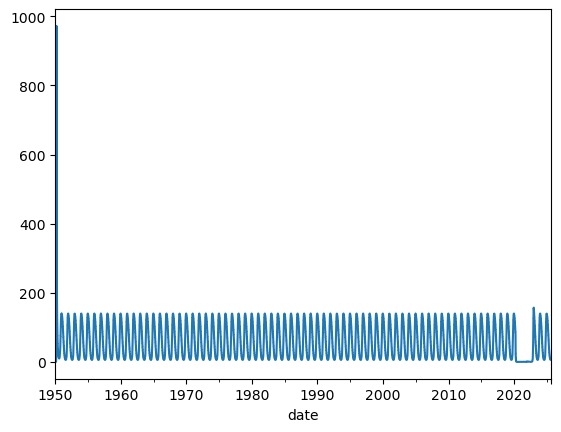

In [5]:
outcomes_df_ref.set_index("date")["incidH"].plot()

In [13]:
# reprocess:
npi_seir = seir.build_npi_SEIR(
    modinf=modinf, load_ID=False, sim_id2load=None, config=config, 
    bypass_DF=snpi_df_ref
)
if modinf.npi_config_outcomes:
    npi_outcomes = outcomes.build_outcome_modifiers(
                modinf=modinf,
                load_ID=False,
                sim_id2load=None,
                config=config,
                bypass_DF=hnpi_df_ref
            )
    

# reduce them
parameters = modinf.parameters.parameters_reduce(p_draw, npi_seir)
        # Parse them
parsed_parameters = modinf.compartments.parse_parameters(
    parameters, modinf.parameters.pnames, unique_strings
)

states = seir.steps_SEIR(
    modinf,
    parsed_parameters,
    transition_array,
    proportion_array,
    proportion_info,
    initial_conditions,
    seeding_data,
    seeding_amounts,
)

seir_out_df = seir.postprocess_and_write(
    0, modinf, states, p_draw, npi_seir, seeding_data
)

outcomes_df, hpar_df = outcomes.compute_all_multioutcomes(
    modinf=modinf,
    sim_id2write=0,
    parameters=outcomes_parameters,
    loaded_values=None,
    npi=npi_outcomes,
    bypass_seir=seir_out_df
)
outcomes_df, hpar, hnpi = outcomes.postprocess_and_write(
    sim_id=0,
    modinf=modinf,
    outcomes_df=outcomes_df,
    hpar=hpar_df,
    npi=npi_outcomes,
)
outcomes_df = outcomes_df.set_index("date")


INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
13819it [00:22, 625.91it/s]


<Axes: xlabel='date'>

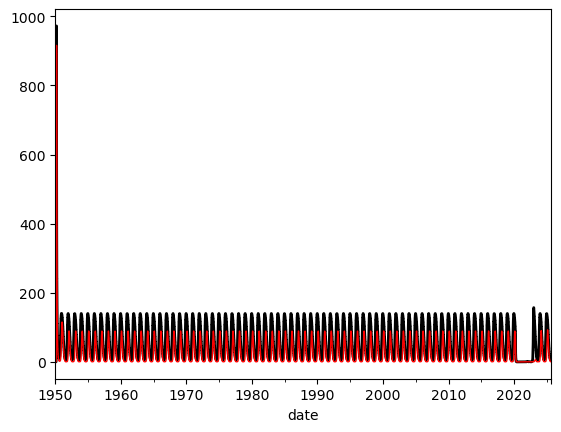

In [14]:
outcomes_df_ref.set_index("date")["incidH"].plot(lw=2, c='k')
outcomes_df.set_index("date")["incidH"].plot(lw=1, c='r')

In [16]:

gt = pd.read_csv(f"{data_dir}/"+gempyor.config["inference"]["gt_data_path"].get())
# gt
statistics = {}
# # Ingoring agreegation and all, assuming by weekP
for stat in gempyor.config["inference"]["statistics"]:
    statistics[gempyor.config["inference"]["statistics"][stat]["sim_var"].get()] = gempyor.config["inference"]["statistics"][stat]["data_var"].get()
statistics
gt = gempyor.read_df(gempyor.config["inference"]["gt_data_path"].get())
gt["date"]= pd.to_datetime(gt['date'])
gt = gt.set_index("date")

gt


,subpop,incidH_all,incidH_0_4,incidH_18_49,incidH_50_64,incidH_5_17,incidH_65_100
date,,,,,,,
1989-01-01,California,7.728136,4.296087,NaN,NaN,0.000000,NaN
1989-01-01,Colorado,2.034232,1.178571,NaN,NaN,0.430358,NaN
1989-01-01,Maryland,0.000000,0.000000,NaN,NaN,0.000000,NaN
1989-01-02,California,8.541624,4.748306,NaN,NaN,0.000000,NaN
1989-01-02,Colorado,2.034232,1.473214,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...
2024-01-10,Colorado,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-10,Maryland,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-11,California,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
statistics

{'incidH_age0to4': 'incidH_0_4',
 'incidH_age5to17': 'incidH_5_17',
 'incidH_age18to49': 'incidH_18_49',
 'incidH_age50to64': 'incidH_50_64',
 'incidH_age65to100': 'incidH_65_100'}

In [31]:
subpop = modinf.subpop_struct.subpop_names[0]

In [36]:
len(gt[gt["subpop"]==subpop].loc[modinf.ti:modinf.tf])

12794

In [42]:
gt_s.index

DatetimeIndex(['1989-01-01', '1989-01-02', '1989-01-03', '1989-01-04',
               '1989-01-05', '1989-01-06', '1989-01-07', '1989-01-08',
               '1989-01-09', '1989-01-10',
               ...
               '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05',
               '2024-01-06', '2024-01-07', '2024-01-08', '2024-01-09',
               '2024-01-10', '2024-01-11'],
              dtype='datetime64[ns]', name='date', length=12794, freq=None)

In [43]:
outcomes_df.index

DatetimeIndex(['1950-01-01', '1950-01-02', '1950-01-03', '1950-01-04',
               '1950-01-05', '1950-01-06', '1950-01-07', '1950-01-08',
               '1950-01-09', '1950-01-10',
               ...
               '2025-08-23', '2025-08-24', '2025-08-25', '2025-08-26',
               '2025-08-27', '2025-08-28', '2025-08-29', '2025-08-30',
               '2025-08-31', '2025-09-01'],
              dtype='datetime64[ns]', name='date', length=27638, freq=None)

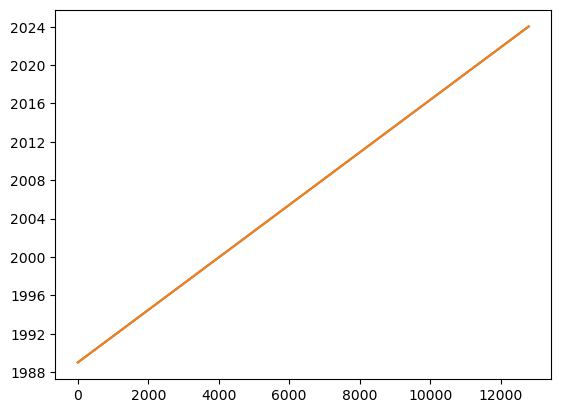

In [47]:
plt.plot(gt_s.index)


In [35]:
len(outcomes_df)

27638

In [26]:

outcomes_df

,subpop,incidH_0prior_age0to2m,incidH_1prior_age0to2m,incidH_2prior_age0to2m,incidH_age0to2m,incidH_0prior_age3to5m,incidH_1prior_age3to5m,incidH_2prior_age3to5m,incidH_age3to5m,incidH_0prior_age6to11m,...,incidH_1prior_age50to64,incidH_2prior_age50to64,incidH_age50to64,incidH_0prior_age65to100,incidH_1prior_age65to100,incidH_2prior_age65to100,incidH_age65to100,incidH,incidH_age0to4,time
date,,,,,,,,,,,,,,,,,,,,,
1950-01-01,Maryland,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1950-01-01
1950-01-02,Maryland,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1950-01-02
1950-01-03,Maryland,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1950-01-03
1950-01-04,Maryland,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1950-01-04
1950-01-05,Maryland,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1950-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-28,Maryland,0.093553,0.004672,0.001628,0.099853,0.039180,0.005363,0.002808,0.047351,0.010093,...,3.344721e-08,0.021419,0.021419,2.086119e-08,1.290053e-07,0.073099,0.073099,0.382238,0.204159,2025-08-28
2025-08-29,Maryland,0.093553,0.004672,0.001628,0.099853,0.039180,0.005363,0.002808,0.047351,0.010093,...,3.344721e-08,0.021419,0.021419,2.086119e-08,1.290053e-07,0.073099,0.073099,0.382238,0.204159,2025-08-29
2025-08-30,Maryland,0.092276,0.004491,0.001562,0.098329,0.038807,0.005203,0.002714,0.046724,0.010077,...,3.292189e-08,0.021007,0.021007,2.044848e-08,1.264965e-07,0.071691,0.071691,0.375774,0.201120,2025-08-30


In [30]:
gt[gt["subpop"]==subpop] # only work for one subpop

,subpop,incidH_all,incidH_0_4,incidH_18_49,incidH_50_64,incidH_5_17,incidH_65_100
date,,,,,,,
1989-01-01,Maryland,0.0,0.0,NaN,NaN,0.0,NaN
1989-01-02,Maryland,0.0,0.0,NaN,NaN,0.0,NaN
1989-01-03,Maryland,0.0,0.0,NaN,NaN,0.0,NaN
1989-01-04,Maryland,0.0,0.0,NaN,NaN,0.0,NaN
1989-01-05,Maryland,0.0,0.0,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...
2024-01-07,Maryland,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-08,Maryland,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-09,Maryland,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:

log_loss = 0
for subpop in modinf.subpop_struct.subpop_names:
    gt_s = gt[gt["subpop"]==subpop].loc[modinf.ti:modinf.tf].drop(["subpop"],axis=1).resample("W-SAT").sum()
    outcomes_df_s = outcomes_df[outcomes_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[min(gt_s.index):max(gt_s.index)].resample("W-SAT").sum() # todo sub subpop here
    for key, value in statistics.items():
        assert outcomes_df_s[key].shape == gt_s[value].shape
        log_loss += sum(np.log((outcomes_df_s[key]-gt_s[value])**2))

print(log_loss)


25154.643180992658


In [113]:


fitted_params = {
    "ptype":[],
    "pname":[],
    "pdist":[],
    "ub":[],
    "lb":[],
}
n_params=0

print("SEIR MODIFIERS")
for npi in gempyor.config["seir_modifiers"]["modifiers"].get():
    if gempyor.config["seir_modifiers"]["modifiers"][npi]["perturbation"].exists():
        c = config["seir_modifiers"]["modifiers"][npi]
        fitted_params["ptype"].append("snpi")
        fitted_params["pname"].append(npi)
        fitted_params["pdist"].append(c["value"].as_random_distribution())
        fitted_params["lb"].append(c["value"]["a"].get())
        fitted_params["ub"].append(c["value"]["b"].get())
        print(f" >> {npi} has perturbation, recording")
        n_params+=len(modinf.subpop_struct.subpop_names)
        
print("OUTCOMES MODIFIERS")   
for npi in gempyor.config["outcome_modifiers"]["modifiers"].get():
    if gempyor.config["outcome_modifiers"]["modifiers"][npi]["perturbation"].exists():
        c = config["outcome_modifiers"]["modifiers"][npi]
        fitted_params["ptype"].append("hnpi")
        fitted_params["pname"].append(npi)
        fitted_params["pdist"].append(c["value"].as_random_distribution())
        fitted_params["lb"].append(c["value"]["a"].get())
        fitted_params["ub"].append(c["value"]["b"].get())
        print(f" >> {npi} has perturbation, recording")
        n_params+=len(modinf.subpop_struct.subpop_names)

fitted_params

SEIR MODIFIERS
 >> Ro_mod has perturbation, recording
 >> covid_mod has perturbation, recording
 >> omicron_mod has perturbation, recording
 >> seas_amp_mod has perturbation, recording
 >> seas_offset_mod has perturbation, recording
OUTCOMES MODIFIERS
 >> IHRadj has perturbation, recording


{'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi'],
 'pname': ['Ro_mod',
  'covid_mod',
  'omicron_mod',
  'seas_amp_mod',
  'seas_offset_mod',
  'IHRadj'],
 'pdist': [<bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3189a5f10>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3189a7010>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3189a7a10>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3189a5c50>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3189a6390>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3189a6210>>],
 'ub': [10, 1, 1, 1, 1, 4],
 'lb': [0, 0, 0, 0, 0, 0]}

In [114]:
proposal = np.random.random(len(fitted_params["ptype"]))*1.5
if (proposal < fitted_params["lb"]).any() or (proposal > fitted_params["ub"]).any():
    print("out of bound")


In [80]:
hnpi_

{'IHRadj': {'initial_value': <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x318935910>>,
  'lb': 0,
  'up': 4},
 'Ro_mod': {'initial_value': <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3184a62d0>>,
  'lb': 0,
  'up': 10},
 'covid_mod': {'initial_value': <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3189241d0>>,
  'lb': 0,
  'up': 1},
 'omicron_mod': {'initial_value': <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x318925550>>,
  'lb': 0,
  'up': 1},
 'seas_amp_mod': {'initial_value': <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x318934e90>>,
  'lb': 0,
  'up': 1},
 'seas_offset_mod': {'initial_value': <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x318934490>>,
  'lb': 0,
  'u

In [60]:
config["seir_modifiers"]["modifiers"][npi].get()

OrderedDict([('method', 'StackedModifier'),
             ('modifiers',
              ['Ro_mod',
               'covid_mod',
               'omicron_mod',
               'seas_amp_mod',
               'seas_offset_mod'])])

In [123]:
snpi_df_mod = snpi_df_ref.copy(deep=True)
hnpi_df_mod = hnpi_df_ref.copy(deep=True)

In [115]:
snpi_df_mod

,subpop,npi_name,start_date,end_date,parameter,reduction
subpop,,,,,,
Maryland,Maryland,Ro_mod,1950-01-01,2025-09-01,ro,1.193623
Maryland,Maryland,covid_mod,2020-03-15,2021-03-15,ro,0.535005
Maryland,Maryland,omicron_mod,2021-12-01,2022-03-15,ro,0.706578
Maryland,Maryland,seas_amp_mod,1950-01-01,2025-09-01,seas_amp,0.242099
Maryland,Maryland,seas_offset_mod,1950-01-01,2025-09-01,seas_offset,0.947654


In [124]:
for i in range(n_params):
    if fitted_params["ptype"][i] == "snpi":
        snpi_df_mod.loc[snpi_df_mod["npi_name"] == fitted_params["pname"][i],"reduction"] = proposal[i]
    elif fitted_params["ptype"][i] == "hnpi":
        hnpi_df_mod.loc[hnpi_df_mod["npi_name"] == fitted_params["pname"][i],"reduction"] = proposal[i]

In [121]:
snpi_df_mod

,subpop,npi_name,start_date,end_date,parameter,reduction
subpop,,,,,,
Maryland,Maryland,Ro_mod,1950-01-01,2025-09-01,ro,0.318804
Maryland,Maryland,covid_mod,2020-03-15,2021-03-15,ro,0.644541
Maryland,Maryland,omicron_mod,2021-12-01,2022-03-15,ro,0.214926
Maryland,Maryland,seas_amp_mod,1950-01-01,2025-09-01,seas_amp,0.527090
Maryland,Maryland,seas_offset_mod,1950-01-01,2025-09-01,seas_offset,0.595517


In [122]:
proposal

array([0.31880406, 0.64454079, 0.21492594, 0.52708982, 0.59551713,
       1.27198253])

In [125]:
hnpi_df_mod

,subpop,npi_name,start_date,end_date,parameter,reduction
subpop,,,,,,
Maryland,Maryland,IHRadj,1950-01-01,2025-09-01,incidh_frac,1.271983
